In [45]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn import linear_model

def model(x):
    return 1.0/(1.0+np.exp(-x))

def plot_boundaries(X_train, y_train, score, probability_func, degree = None, n_colors = 100, mesh_res = 1000, ax = None):
    X = X_train #np.vstack((X_test, X_train))
    margin_x = (X[:, 0].max() - X[:, 0].min())*0.05
    margin_y = (X[:, 1].max() - X[:, 1].min())*0.05
    x_min, x_max = X[:, 0].min() - margin_x, X[:, 0].max() + margin_x
    y_min, y_max = X[:, 1].min() - margin_y, X[:, 1].max() + margin_y
    hx = (x_max-x_min)/mesh_res
    hy = (y_max-y_min)/mesh_res
    
    print(margin_x,x_min,x_max,hx)
    print(margin_y,y_min,y_max,hy)
    
    x_domain = np.arange(x_min, x_max, hx)
    y_domain = np.arange(y_min, y_max, hy)   
    
    xx, yy = np.meshgrid(x_domain, y_domain)

    if ax is None:
        ax = plt.subplot(1, 1, 1)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if degree is not None:
        polynomial_set = get_polynimial_set(np.c_[xx.ravel(), yy.ravel()], degree = degree)
        Z = probability_func(polynomial_set)[:, 1]
    else:
        Z_aux = probability_func(np.c_[xx.ravel(), yy.ravel()])
        Z = Z_aux[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    cf = ax.contourf(xx, yy, Z, n_colors, vmin=0., vmax=1., cmap=cm, alpha=.8)
    plt.colorbar(cf, ax=ax)
    #plt.colorbar(Z,ax=ax)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k', s=100, marker='o')
    
    boundary_line = np.where(np.abs(Z-0.5)<0.001)
    
    ax.scatter(x_domain[boundary_line[1]], y_domain[boundary_line[0]], color='k', alpha=0.5, s=1)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    #ax.set_xticks(())
    #ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=40, horizontalalignment='right')

def nCr(n,r):
    f = math.factorial
    return int(f(n) / f(r) / f(n-r))

def get_polynimial_set(X, degree = 12):
    # Recibe el dataset X de numero_de_muestras x features  y devuelve una matriz con todas las combinaciones 
    # De los productos del grado indicado en degree
    k = 2
    n = degree + k
    pos = 0
    X_mat = np.zeros((X.shape[0],nCr(n,k)))
    for i in range(degree + 1):
        for j in range(i+1):
            X_mat[:,pos] = (X[:,0]**(i-j))*X[:,1]**j
            pos = pos + 1
    return X_mat

In [50]:
# Importo los datos: chip_tests.txt

data_chip = np.genfromtxt("./datasets/chip_tests.txt", delimiter=",")

x = data_chip[:,0:2]
y = data_chip[:,2]

print('Shape x:', np.shape(x))
print('Shape y:',np.shape(y))

# Definicion train_set y test_set

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)

print('Shape x-train:', np.shape(x_train))
print('Shape x-test:', np.shape(x_test))

Shape x: (118, 2)
Shape y: (118,)
Shape x-train: (70, 2)
Shape x-test: (48, 2)


Score train-data: 0.5857142857142857
Score test-data: 0.5
Coeficientes: [[-0.88454093  0.06805697]]
Intercept: [0.14182364]


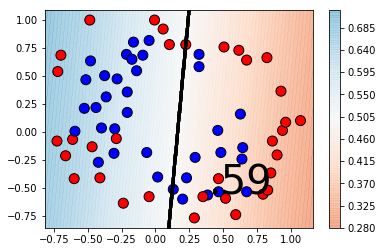

In [28]:
# Definicion del modelo - LIBLINEAR

clf = linear_model.LogisticRegression(C=1e5,tol=0.0001)  #solver=‘liblinear’ 
clf.fit(x_train,y_train)

# Score de la clasificacion 
scoreTest = clf.score(x_test, y_test)
scoreTrain = clf.score(x_train, y_train)

print('Score train-data:', scoreTrain)
print('Score test-data:', scoreTest)
print('Coeficientes:', clf.coef_)
print('Intercept:', clf.intercept_)

plot_boundaries(x_train, y_train, scoreTrain, clf.predict_proba)

Score train-data: 0.5857142857142857
Score test-data: 0.5


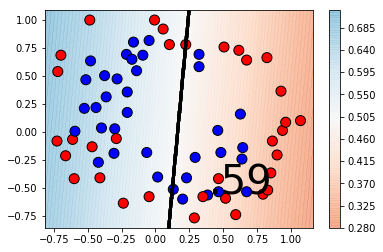

In [10]:
# Definicion del modelo - SAG

clf = linear_model.LogisticRegression(C=1e5,solver='sag',tol=1e-4)  
clf.fit(x_train,y_train)

# Score de la clasificacion 
scoreTest = clf.score(x_test, y_test)
scoreTrain = clf.score(x_train, y_train)

print('Score train-data:', scoreTrain)
print('Score test-data:', scoreTest)
print('Coeficientes:', clf.coef_)
print('Intercept:', clf.intercept_)

plot_boundaries(x_train, y_train, scoreTrain, clf.predict_proba)

In [ ]:
# Grafico Sigmoide - degree = 1

ax = plt.subplot(1, 1, 1)
#ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', s=100, marker='o') #cmap=cm_bright,
loss = model(x_train*clf.coef_ + clf.intercept_).ravel()
ax.scatter((x_train*clf.coef_ + clf.intercept_).ravel(),loss, color='red')
loss = model(x_test*clf.coef_ + clf.intercept_).ravel()
ax.scatter((x_test*clf.coef_ + clf.intercept_).ravel(),loss, color='blue')
plt.show()

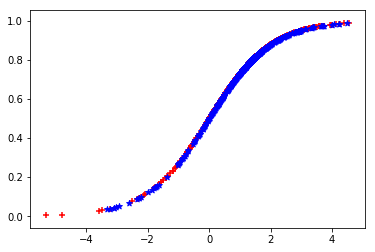

In [157]:
# Grafico Sigmoide - degree = k

def plot_sigmoide(x_train, x_test, lr_coef, lr_intercetp):
    ax = plt.subplot(1, 1, 1)
    loss = model(x_train*lr_coef + lr_intercetp).ravel()
    ax.scatter((x_train*lr_coef + lr_intercetp).ravel(),loss, marker='+',color='red')
    loss = model(x_test*lr_coef + lr_intercetp).ravel()
    ax.scatter((x_test*lr_coef + lr_intercetp).ravel(),loss, marker='*',color='blue')
    plt.show()
    
plot_sigmoide(x_k_train, x_k_test, clf.coef_, clf.intercept_)

In [155]:
# Definicion del modelo orden n > 1

degree_max = 20

flg_plot = 0

score_train = np.zeros((degree_max,1))
score_test = np.zeros((degree_max,1))

#fig, ax_k = plt.subplots(degree_max, 1)
if flg_plot:
    fig, ax_k = plt.subplots(int(degree_max/2), 2, figsize=(20,6))

coefs_array_mean = []
coefs_array_std = []
coefs_abs_max = []
coef_intercept = []

for k in range(1,degree_max+1):
           
    #print('Iteracion:', k)

    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)
    
    x_k_train = get_polynimial_set(x_train, degree = k)
    x_k_test = get_polynimial_set(x_test, degree = k)

    #print('Shape x-train:', np.shape(x_k_train))
    #print('Shape x-test:', np.shape(x_k_test))

    clf = linear_model.LogisticRegression(C=1e10,fit_intercept=True,solver='sag',max_iter=1000)  #,tol=0.0001, max_iter=2000, solver='sag', fit_intercept=False
    clf.fit(x_k_train,y_train)

    # Score de la clasificacion 
    score_train[k-1] = clf.score(x_k_train, y_train)
    score_test[k-1] = clf.score(x_k_test, y_test)
    
    #print('Score train:',score_train[k-1])
    #print('Score test:',score_test[k-1])
 
    if flg_plot:
        if k % 2: 
            plot_boundaries(x_train, y_train, score_train[k-1], clf.predict_proba, degree = k, ax = ax_k[int((k-1)/2),0])
        else:
            plot_boundaries(x_train, y_train, score_train[k-1], clf.predict_proba, degree = k, ax = ax_k[int(k/2-1),1]) 
     
    coefs_array_mean.append(clf.coef_.mean())
    coefs_array_std.append(clf.coef_.std())
    coefs_abs_max.append(np.max(abs(clf.coef_)))
    coef_intercept.append(clf.intercept_)


/home/gabi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


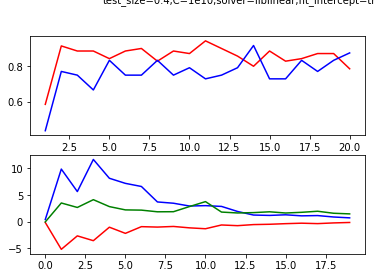

In [156]:
# Grafico del score
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(1,degree_max+1),score_train, color='red')
ax1.plot(range(1,degree_max+1),score_test, color='blue')
ax1.text(1,1.1,'test_size=0.4,C=1e10,solver=liblinear,fit_intercept=true', size=10, horizontalalignment='right',transform=ax.transAxes) #solver=sag,tol=1e-4

ax2.plot(coefs_array_mean, color='red')
ax2.plot(coefs_array_std, color='blue')
ax2.plot(coef_intercept, color='green')